###  Imports

In [1]:
import sys
import numpy as np
from math import sin, cos, atan2, pi
from IPython.display import display, Math, Latex, Markdown, HTML

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

### Data Plotting

In [2]:
'''Plot the true and moved data using Matplotlib'''
def plotData(data1, data2, label1, label2, markersize1 = 20, markersize2 = 20):
    plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    ax.set_title("Point Clouds")

    xdata1 = data1[0, :]
    ydata1 = data1[1, :]
    zdata1 = data1[2, :]
    ax.scatter3D(xdata1, ydata1, zdata1, s= markersize1, label = label1);
    
    xdata2 = data2[0, :]
    ydata2 = data2[1, :]
    zdata2 = data2[2, :]
    ax.scatter3D(xdata2, ydata2, zdata2, s= markersize2, label=label2);
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.legend()

def plotValues(values, label):
    plt.figure(figsize = (10, 4))
    plt.title("Error")
    plt.plot(values, label=label)
    plt.legend()
    plt.grid(True)
    plt.show()

### Data Generation

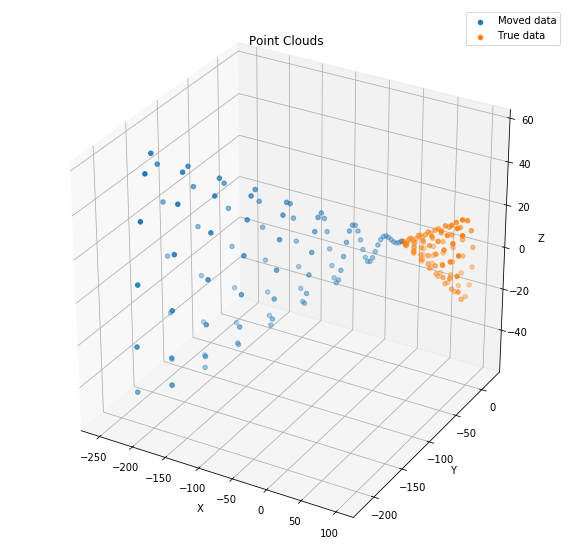

In [3]:
'''Generate data using the sin and cosine functions'''
def generateSpiral(numPoints, angle, shift, scale):
    
    aboutZ = np.array([[cos(angle[2]), -sin(angle[2]), 0], 
                      [sin(angle[2]), cos(angle[2]), 0],
                      [0, 0, 1]])
    aboutY = np.array([[cos(angle[1]), 0, -sin(angle[1])],
                      [0, 1, 0] ,
                      [sin(angle[1]), 0, cos(angle[1])]])
    aboutX = np.array([[1, 0, 0],
                      [0, cos(angle[0]), -sin(angle[0])],
                      [0, sin(angle[0]), cos(angle[0])]])
      
    T = shift
    R = aboutZ.dot(aboutY.dot(aboutX))
    sourceData = np.zeros((3, numPoints))
    sourceData[0, :] = range(0, numPoints)
    sourceData[1, :] = 0.2 * sourceData[0, :] * np.sin(0.5 * sourceData[0, :]) 
    sourceData[2, :] = 0.2 * sourceData[0, :] * np.cos(0.5 * sourceData[0, :]) 
    
    movedData = R.dot(sourceData) + shift
    movedData = movedData*scale
    return sourceData, movedData

'''Assign data to point clouds P and Q''' 
angle = [0, pi, pi/5]
scale = 3
shift = np.array([[0], [0], [0]])
Q, P = generateSpiral(100, angle, shift, scale)

plotData(P, Q, "Moved data", "True data")
plt.show()

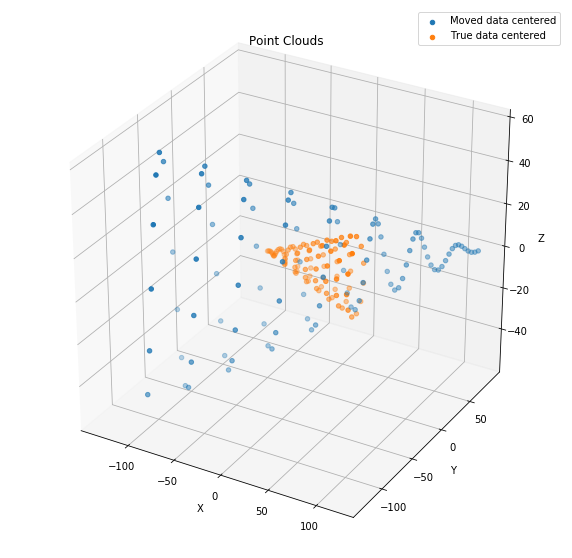

In [4]:
def centerData(data, excludeIndices=[]):
    reducedData = np.delete(data, excludeIndices, axis = 1)
    center = np.array([reducedData.mean(axis = 1)]).T
    return center, data - center

centerP, Pcentered = centerData(P)
centerQ, Qcentered = centerData(Q)
plotData(Pcentered, 
         Qcentered,
         'Moved data centered',
         'True data centered')

### Umeyama Method

In [5]:
def umeyama(src, dst, estimate_scale=True):
    num = src.shape[0]
    dim = src.shape[1]

    src_mean = src.mean(axis=0)
    dst_mean = dst.mean(axis=0)

    src_demean = src - src_mean
    dst_demean = dst - dst_mean

    A = np.dot(dst_demean.T, src_demean) / num

    d = np.ones((dim, ), dtype=np.double)
    if np.linalg.det(A) < 0:
        d[dim - 1] = -1

    T = np.eye(dim + 1, dtype=np.double)

    U, S, V = np.linalg.svd(A)

    rank = np.linalg.matrix_rank(A)
    if rank == 0:
        return np.nan * T
    elif rank == dim - 1:
        if np.linalg.det(U) * np.linalg.det(V) > 0:
            T[:dim, :dim] = np.dot(U, V)
        else:
            s = d[dim - 1]
            d[dim - 1] = -1
            T[:dim, :dim] = np.dot(U, np.dot(np.diag(d), V))
            d[dim - 1] = s
    else:
        T[:dim, :dim] = np.dot(U, np.dot(np.diag(d), V))

    if estimate_scale:
        scale = 1.0 / src_demean.var(axis=0).sum() * np.dot(S, d)
    else:
        scale = 1.0

    T[:dim, dim] = dst_mean - scale * np.dot(T[:dim, :dim], src_mean.T)
    return T, scale

In [6]:
'''Iterations of ICP using Umeyama Method'''
def ICP(P, Q, iterations = 20, kernel=lambda diff: 1.0):
    centerQ, Qcentered = centerData(Q)
    normValues = []
    Pvalues = [P.copy()]
    Pcopy = P.copy()
    for i in range(iterations):
        centerP, Pcentered = centerData(Pcopy)
        normValues.append(np.linalg.norm(Pcentered - Qcentered))
        T, scale = umeyama(Pcopy.T, Q.T)
        R = T[0:3, 0:3]
        t = T[3, 0:3].reshape(3,1)
        Pcopy = R.dot(Pcopy) + t
        Pcopy = Pcopy*scale
        Pvalues.append(Pcopy)
    return Pvalues, normValues

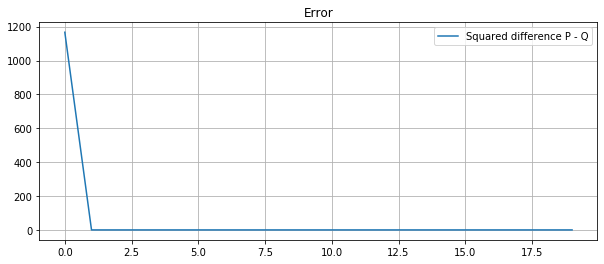

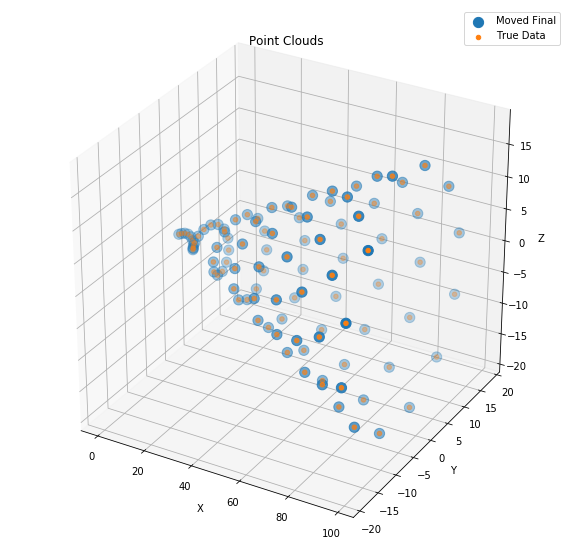

CPU times: user 639 ms, sys: 120 ms, total: 759 ms
Wall time: 451 ms


In [7]:
%%time
Pvalues, normValues = ICP(P, Q)
plotValues(normValues, "Squared difference P - Q")
plotData(Pvalues[-1], Q, 'Moved Final', 'True Data', markersize1 = 105)
plt.show()